<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4

## San Francisco Data

---

[San Francisco provides a wealth of data on the city to the public.](https://data.sfgov.org/) Project 4 is all about exploring this data and modeling interesting relationships with regression.

Project 4 is also much more open-ended than the previous projects. You are more responsible for finding things about the data that interest you, coming up with your own hypothesis about it, and reporting on the analysis you carry out. That being said, there are still specific requirements and restrictions on the type of models you will be constructing.

---

## Notes on the data

We have gone through the above website and pulled out a variety of different datasets that we think are particularly interesting. Some of the datasets are from external sources as well, but all are related to San Francisco. A high level overview of data folders is provided after the project requirements section.

**There is a lot of different data. You are _NOT_ expected to explore all of it or include all of it in analyses.** The point of the project is to focus on aspects of San Francisco that are particularly interesting to you from a modeling point of view. 

**The uncompressed data is a large filesize.** Even the compressed data is pretty large. The data is compressed into a .7z format which has one of the smallest filesizes available. You will likely need a 3rd party app to extract it. 

### Recommended Utilities for .7z
- For OSX [Keka](http://www.kekaosx.com/en/) or [The Unarchiver](http://wakaba.c3.cx/s/apps/unarchiver.html). 
- For Windows [7-zip](http://www.7-zip.org/) is the standard. 
- For Linux try the `p7zip` utility.  `sudo apt-get install p7zip`.

---

## Project requirements

**You will be performing 4 different sections of analysis on the San Francisco data.**

**Models must be regression. This means that your target variable needs to be numeric/continuous**

Do not perform classification models – this will be the topic of week 4.


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 1. Choose a dataset or datasets of interest to you and perform EDA

---

1. Explain what the data is. This may include multiple csv files. Some of this data has hard to understand codes representing the variables. Nearly all data is pulled from https://data.sfgov.org/ so this is a very good resource for determining what the data is.
- Clean the data.
- Develop and state clearly a hypothesis about the data that you would want to test.
- Create some initial visualizations on the portions of the data relevant to your hypothesis.

In [1]:
import numpy as np
import pandas as pd, patsy
from scipy.stats import spearmanr
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from sklearn.grid_search import GridSearchCV
from sklearn import metrics


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Briefly looking at all the Yelp datasets
From the Health Department's inspection and scoring of SF restaurants.

In [2]:
businesses = pd.read_csv('/Users/VanessaG/desktop/DSI-SF-2-vnessified/datasets/sf/yelp/businesses.csv')

In [3]:
businesses.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number
0,10,TIRAMISU KITCHEN,033 BELDEN PL,San Francisco,CA,94104,37.791116,-122.403816,+14154217044
1,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262


In [4]:
code_legend = pd.read_csv('/Users/VanessaG/desktop/DSI-SF-2-vnessified/datasets/sf/yelp/code_legend.csv')

In [5]:
code_legend

,Minimum_Score,Maximum_Score,Description
0,0,70,Poor
1,71,85,Needs Improvement
2,86,90,Adequate
3,91,100,Good


In [6]:
inspections = pd.read_csv('/Users/VanessaG/desktop/DSI-SF-2-vnessified/datasets/sf/yelp/inspections.csv')

In [7]:
inspections.head(2)

,business_id,score,date,type
0,10,94,20140729,routine
1,10,92,20140114,routine


In [8]:
neighborhoods = pd.read_csv('/Users/VanessaG/desktop/DSI-SF-2-vnessified/datasets/sf/yelp/neighborhood_legend.csv')

In [9]:
neighborhoods.head(2)

,Neighborhood,City,Population,Polygon
0,Alamo Square,San Francisco,"5,617",<Polygon><outerBoundaryIs><LinearRing><tessell...
1,Bayview,San Francisco,"35,890",<Polygon><outerBoundaryIs><LinearRing><tessell...


In [10]:
violations = pd.read_csv('/Users/VanessaG/desktop/DSI-SF-2-vnessified/datasets/sf/yelp/violations.csv')

In [11]:
violations.head(2)

,business_id,date,description
0,10,20140729,Insufficient hot water or running water [ dat...
1,10,20140729,Unapproved or unmaintained equipment or utensi...


### Dataset I'll be using
Looks like the above csv files all originate from this larger one I want to explore. The bulk of the columns are binary variables created from keywords in the description column. 

In [12]:
violations_parsed = pd.read_csv('/Users/VanessaG/desktop/DSI-SF-2-vnessified/datasets/sf/yelp/violations_parsed_words.csv')

/Users/VanessaG/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
violations_parsed.head(2)

,business_id,score,date,type,violation_count,days_since_first_violation,name,address,city,state,...,washed fruits,wastewater,wastewater contamination,wastewater disposal,water,water running,wiping,wiping cloths,worker,worker safety
0,10.0,92.0,2014-01-14,routine,1.0,0.0,TIRAMISU KITCHEN,033 BELDEN PL,San Francisco,CA,...,0,0,0,0,0,0,0,0,0,0
1,10.0,92.0,2014-01-14,routine,1.0,0.0,TIRAMISU KITCHEN,033 BELDEN PL,San Francisco,CA,...,0,0,0,0,0,0,0,0,0,0


In [14]:
violations_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32455 entries, 0 to 32454
Columns: 393 entries, business_id to worker safety
dtypes: float64(8), int64(373), object(12)
memory usage: 97.3+ MB


In [15]:
#just want to see all the column names
list(violations_parsed.columns)

['business_id',
 'score',
 'date',
 'type',
 'violation_count',
 'days_since_first_violation',
 'name',
 'address',
 'city',
 'state',
 'postal_code',
 'latitude',
 'longitude',
 'phone_number',
 'polygon',
 'neighborhood',
 'population',
 'score_code',
 'business_count',
 'description',
 '200',
 '200 feet',
 'adulterated',
 'adulterated food',
 'advisory',
 'advisory provided',
 'animal',
 'approved',
 'approved commissary',
 'area',
 'area garbage',
 'available',
 'building',
 'building permit',
 'card',
 'card available',
 'ceilings',
 'certificate',
 'certificate food',
 'certified',
 'certified food',
 'charge',
 'charge food',
 'clean',
 'clean properly',
 'cleaned',
 'cleaned sanitized',
 'cloths',
 'cloths clean',
 'commissary',
 'communicable',
 'communicable disease',
 'condition',
 'conditions',
 'constructed',
 'constructed toilet',
 'consumer',
 'consumer advisory',
 'contact',
 'contact surfaces',
 'containers',
 'containers area',
 'contaminated',
 'contaminated adultera

In [16]:
#the non-binary variables
violations_parsed.columns[0:20]

Index([u'business_id', u'score', u'date', u'type', u'violation_count',
       u'days_since_first_violation', u'name', u'address', u'city', u'state',
       u'postal_code', u'latitude', u'longitude', u'phone_number', u'polygon',
       u'neighborhood', u'population', u'score_code', u'business_count',
       u'description'],
      dtype='object')

In [17]:
first_20 = violations_parsed.iloc[:,:20]
first_20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32455 entries, 0 to 32454
Data columns (total 20 columns):
business_id                   32455 non-null float64
score                         32455 non-null float64
date                          32455 non-null object
type                          32455 non-null object
violation_count               32455 non-null float64
days_since_first_violation    32455 non-null float64
name                          32455 non-null object
address                       32455 non-null object
city                          32455 non-null object
state                         32455 non-null object
postal_code                   31975 non-null object
latitude                      32455 non-null float64
longitude                     32455 non-null float64
phone_number                  30293 non-null object
polygon                       32455 non-null float64
neighborhood                  32455 non-null object
population                    32455 non-null object


In [18]:
#convert date to datetime
violations_parsed['date'] = pd.to_datetime(violations_parsed['date'], format='%Y/%m/%d')

In [19]:
violations_parsed.date.dtypes

dtype('<M8[ns]')

In [20]:
violations_parsed.date.describe()

count                   32455
unique                    779
top       2014-06-03 00:00:00
freq                      139
first     2013-04-22 00:00:00
last      2016-04-20 00:00:00
Name: date, dtype: object

In [21]:
#Looking at date, I think it would be interesting to plot against score... 
#or even make binary variables for linear regression...well maybe just year, as that would only add a few more columns
#although I should probably stop making additional columns at this point

violations_parsed['month'] = violations_parsed['date'].map(lambda val: val.month)
violations_parsed['year'] = violations_parsed['date'].map(lambda val: val.year)

In [22]:
violations_parsed[["score", "month", "year"]].head(2)

,score,month,year
0,92.0,1,2014
1,92.0,1,2014


### Below I'm figuring out what columns could be useful/interesting in regarding to my target variable

In [23]:
#columns with only one value - not useful
for c in violations_parsed.columns:
    unique = len(violations_parsed[c].unique())
    if unique == 1:
        print c, unique

city 1
state 1


In [24]:
#columns with 2 unique values but not necessarily 0 or 1 - for example type
for c in violations_parsed.columns:
    unique = len(violations_parsed[c].unique())
    if unique == 2:
        print c, unique

type 2
200 2
200 feet 2
adulterated 2
adulterated food 2
advisory 2
advisory provided 2
animal 2
approved 2
approved commissary 2
area 2
area garbage 2
available 2
building 2
building permit 2
card 2
card available 2
ceilings 2
certificate 2
certificate food 2
certified 2
certified food 2
charge 2
charge food 2
clean 2
clean properly 2
cleaned 2
cleaned sanitized 2
cloths 2
cloths clean 2
commissary 2
communicable 2
communicable disease 2
condition 2
conditions 2
constructed 2
constructed toilet 2
consumer 2
consumer advisory 2
contact 2
contact surfaces 2
containers 2
containers area 2
contaminated 2
contaminated adulterated 2
contamination 2
control 2
control measure 2
cooking 2
cooking time 2
cooling 2
cooling methods 2
cottage 2
cottage food 2
defective 2
defective plumbing 2
degraded 2
degraded floors 2
discharge 2
discharge employee 2
disease 2
display 2
disposal 2
dressing 2
dressing rooms 2
eating 2
eating smoking 2
employee 2
employee communicable 2
employee eating 2
employee 

In [25]:
#columns with more than 2 unique values
for c in violations_parsed.columns:
    unique = len(violations_parsed[c].unique())
    if unique > 2:
        print c, unique

business_id 3705
score 49
date 779
violation_count 8
days_since_first_violation 980
name 3427
address 3516
postal_code 53
latitude 2918
longitude 2971
phone_number 3175
polygon 44
neighborhood 44
population 42
score_code 4
business_count 40
description 130
month 12
year 4


In [26]:
#mask for the true binary(0,1) variables 
binary_cols = [col for col in violations_parsed
             if violations_parsed[[col]].isin([0, 1]).all().values]


In [27]:
violations_parsed[binary_cols].shape

(32455, 373)

In [28]:
#I realize there's probably not any NaNS here but still I like to check
violations_parsed[binary_cols].isnull().values.any()

False

In [29]:
#so all but 20 columns are currently non-binary
violations_parsed.shape

(32455, 395)

In [30]:
#mask for non-binary columns
not_binary_cols = [x for x in violations_parsed.columns if x not in binary_cols]

In [31]:
not_binary_cols

['business_id',
 'score',
 'date',
 'type',
 'violation_count',
 'days_since_first_violation',
 'name',
 'address',
 'city',
 'state',
 'postal_code',
 'latitude',
 'longitude',
 'phone_number',
 'polygon',
 'neighborhood',
 'population',
 'score_code',
 'business_count',
 'description',
 'month',
 'year']

In [32]:
violations_parsed[not_binary_cols].head(2)

,business_id,score,date,type,violation_count,days_since_first_violation,name,address,city,state,...,longitude,phone_number,polygon,neighborhood,population,score_code,business_count,description,month,year
0,10.0,92.0,2014-01-14,routine,1.0,0.0,TIRAMISU KITCHEN,033 BELDEN PL,San Francisco,CA,...,-122.403816,1.41542e+10,10.0,Downtown,"13,000",good,112.0,Inadequate and inaccessible handwashing facili...,1,2014
1,10.0,92.0,2014-01-14,routine,1.0,0.0,TIRAMISU KITCHEN,033 BELDEN PL,San Francisco,CA,...,-122.403816,1.41542e+10,10.0,Downtown,"13,000",good,112.0,Unclean or degraded floors walls or ceilings,1,2014


In [33]:
#looking for missing values in the non-binary columns
#before dropping, NaNs, I'll subset my interesting variables to lose as few rows as possible
violations_parsed[not_binary_cols].isnull().sum()

business_id                      0
score                            0
date                             0
type                             0
violation_count                  0
days_since_first_violation       0
name                             0
address                          0
city                             0
state                            0
postal_code                    480
latitude                         0
longitude                        0
phone_number                  2162
polygon                          0
neighborhood                     0
population                       0
score_code                       0
business_count                   0
description                   2176
month                            0
year                             0
dtype: int64

In [34]:
#I was curious if this variable should be treated as continous or categorical
violations_parsed.violation_count.value_counts()

1.0    10692
2.0     9688
3.0     7345
4.0     3434
5.0     1004
6.0      229
7.0       56
8.0        7
Name: violation_count, dtype: int64

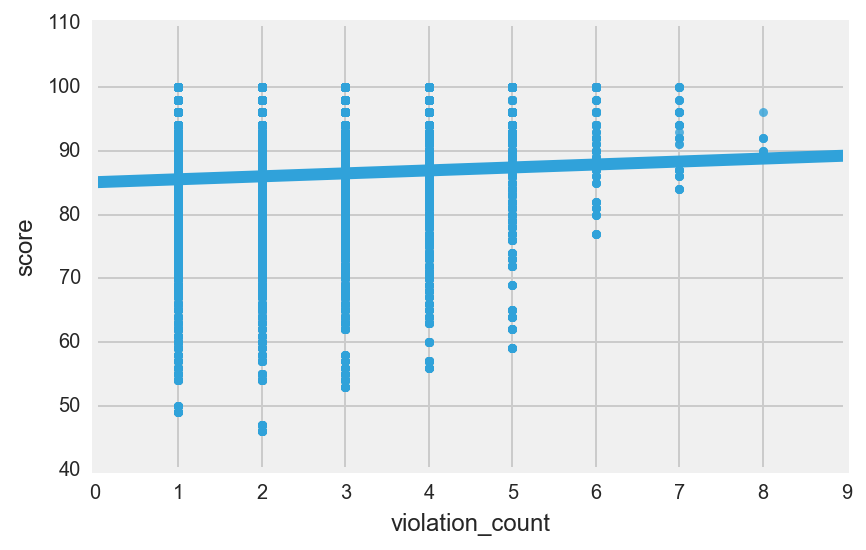

In [35]:
#the idea here to to see if there's a linear relationship between score and violation_count
#if there is I'd keep it as a continuous variable, if not I'd make it categorical
sns.regplot(x='violation_count', y='score', data=violations_parsed)

In [36]:
#this is a better gauge of linearity between score and violation_count... 
#implies there's not linear relationship, so it's making this categorical is the best bet
#I'll use patsy to binarize this
spearmanr(violations_parsed.score.values, violations_parsed.violation_count.values)

SpearmanrResult(correlation=0.045766295461716899, pvalue=1.5982323483942548e-16)

In [37]:
#population is object, want float
violations_parsed[not_binary_cols].dtypes

business_id                          float64
score                                float64
date                          datetime64[ns]
type                                  object
violation_count                      float64
days_since_first_violation           float64
name                                  object
address                               object
city                                  object
state                                 object
postal_code                           object
latitude                             float64
longitude                            float64
phone_number                          object
polygon                              float64
neighborhood                          object
population                            object
score_code                            object
business_count                       float64
description                           object
month                                  int64
year                                   int64
dtype: obj

In [38]:
violations_parsed['population'] = violations_parsed['population'].str.replace(',', '').astype(float)

In [39]:
violations_parsed.population.value_counts().head()

13000.0    2441
59297.0    2309
47234.0    2176
85252.0    2031
20171.0    1745
Name: population, dtype: int64

In [40]:
#is it normal to feel a constant compulsion to check for NaNs? haha
violations_parsed.population.isnull().sum()

0

### My hypothesis

Health scores can be predicted by neighborhood and additonal factors such as date, violation info, population and business count.

#### Target variable:
score

#### Predictor variables:
date (more specifically month or year), violation_count, days_since_first_violation, neighborhood, population, business_count

Below I subset the additional sensible variables to look at more in depth.
There are also 373 columns of the binary variables that were extracted from the description column but for the sake of time management I'm omitting exploring those... for now.

In [41]:
violations_parsed[not_binary_cols].columns

Index([u'business_id', u'score', u'date', u'type', u'violation_count',
       u'days_since_first_violation', u'name', u'address', u'city', u'state',
       u'postal_code', u'latitude', u'longitude', u'phone_number', u'polygon',
       u'neighborhood', u'population', u'score_code', u'business_count',
       u'description', u'month', u'year'],
      dtype='object')

In [42]:
interesting_vars = violations_parsed[['score', 'date', 'month', 'year', 'violation_count',\
                                      'days_since_first_violation', 'neighborhood',\
                                      'population', 'business_count']]

In [43]:
interesting_vars.shape

(32455, 9)

In [44]:
interesting_vars.head()

,score,date,month,year,violation_count,days_since_first_violation,neighborhood,population,business_count
0,92.0,2014-01-14,1,2014,1.0,0.0,Downtown,13000.0,112.0
1,92.0,2014-01-14,1,2014,1.0,0.0,Downtown,13000.0,112.0
2,92.0,2014-01-14,1,2014,1.0,0.0,Downtown,13000.0,112.0
3,94.0,2014-07-29,7,2014,2.0,196.0,Downtown,13000.0,112.0
4,94.0,2014-07-29,7,2014,2.0,196.0,Downtown,13000.0,112.0


In [45]:
#kinda looking for outliers... still not sure the best approach for that. need to do more research on it
#cursory analysis - stds for days_since_first_violation, population, business_count are very high
interesting_vars.describe()

,score,month,year,violation_count,days_since_first_violation,population,business_count
count,32455.000000,32455.000000,32455.000000,32455.000000,32455.000000,32455.000000,32455.000000
mean,86.101186,6.131567,2014.127161,2.239439,321.846372,25027.507811,130.471607
std,9.386847,3.254788,0.929283,1.167865,307.113839,25657.641665,108.646587
min,46.000000,1.000000,2013.000000,1.000000,0.000000,460.000000,2.000000
25%,81.000000,3.000000,2013.000000,1.000000,0.000000,9701.000000,44.000000
50%,88.000000,6.000000,2014.000000,2.000000,248.000000,13000.000000,100.000000
75%,93.000000,9.000000,2015.000000,3.000000,548.000000,25067.000000,186.000000
max,100.000000,12.000000,2016.000000,8.000000,1082.000000,100574.000000,379.000000


In [46]:
#well this pearson correlation matrix doesn't look too promising for linear regression
interesting_vars.corr()

,score,month,year,violation_count,days_since_first_violation,population,business_count
score,1.000000,-0.021834,-0.035767,0.057639,-0.006737,-0.063274,0.000090
month,-0.021834,1.000000,-0.427451,-0.120169,-0.154518,-0.030790,-0.019179
year,-0.035767,-0.427451,1.000000,0.765577,0.881644,0.006075,0.012844
violation_count,0.057639,-0.120169,0.765577,1.000000,0.902845,0.025185,-0.000037
days_since_first_violation,-0.006737,-0.154518,0.881644,0.902845,1.000000,0.008374,0.007562
population,-0.063274,-0.030790,0.006075,0.025185,0.008374,1.000000,0.332106
business_count,0.000090,-0.019179,0.012844,-0.000037,0.007562,0.332106,1.000000


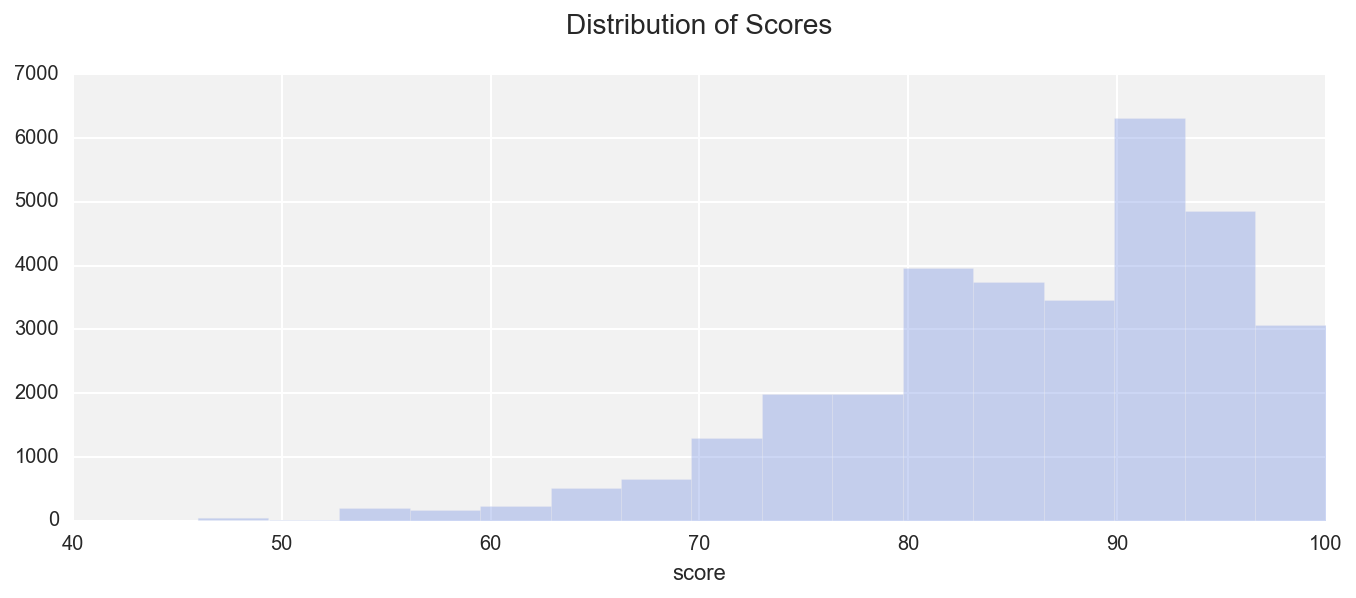

In [47]:
#thought it'd be good to look at the distribution of scores... kinda what I expected
sns.set(rc={"figure.figsize": (10, 4)})
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
rate_dist = sns.distplot(interesting_vars['score'],kde=False, bins=16, color="#819ae4")
rate_dist.set_title('Distribution of Scores' '\n', fontsize=14)
plt.show()

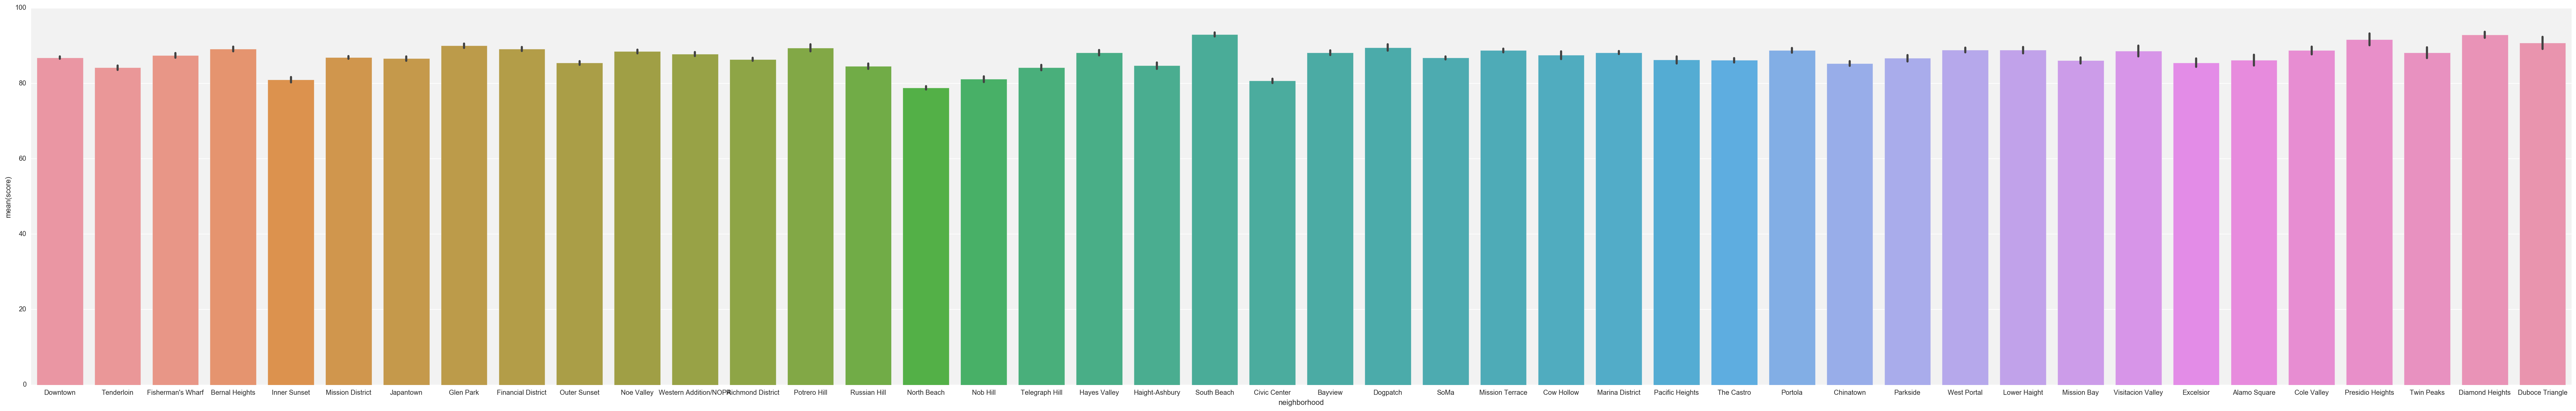

In [48]:
#I'd like to sort this by score but couldn't figure out how
sns.set(rc={"figure.figsize": (60, 10)})
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
sns.barplot(x='neighborhood', y='score', data=interesting_vars)
plt.show()

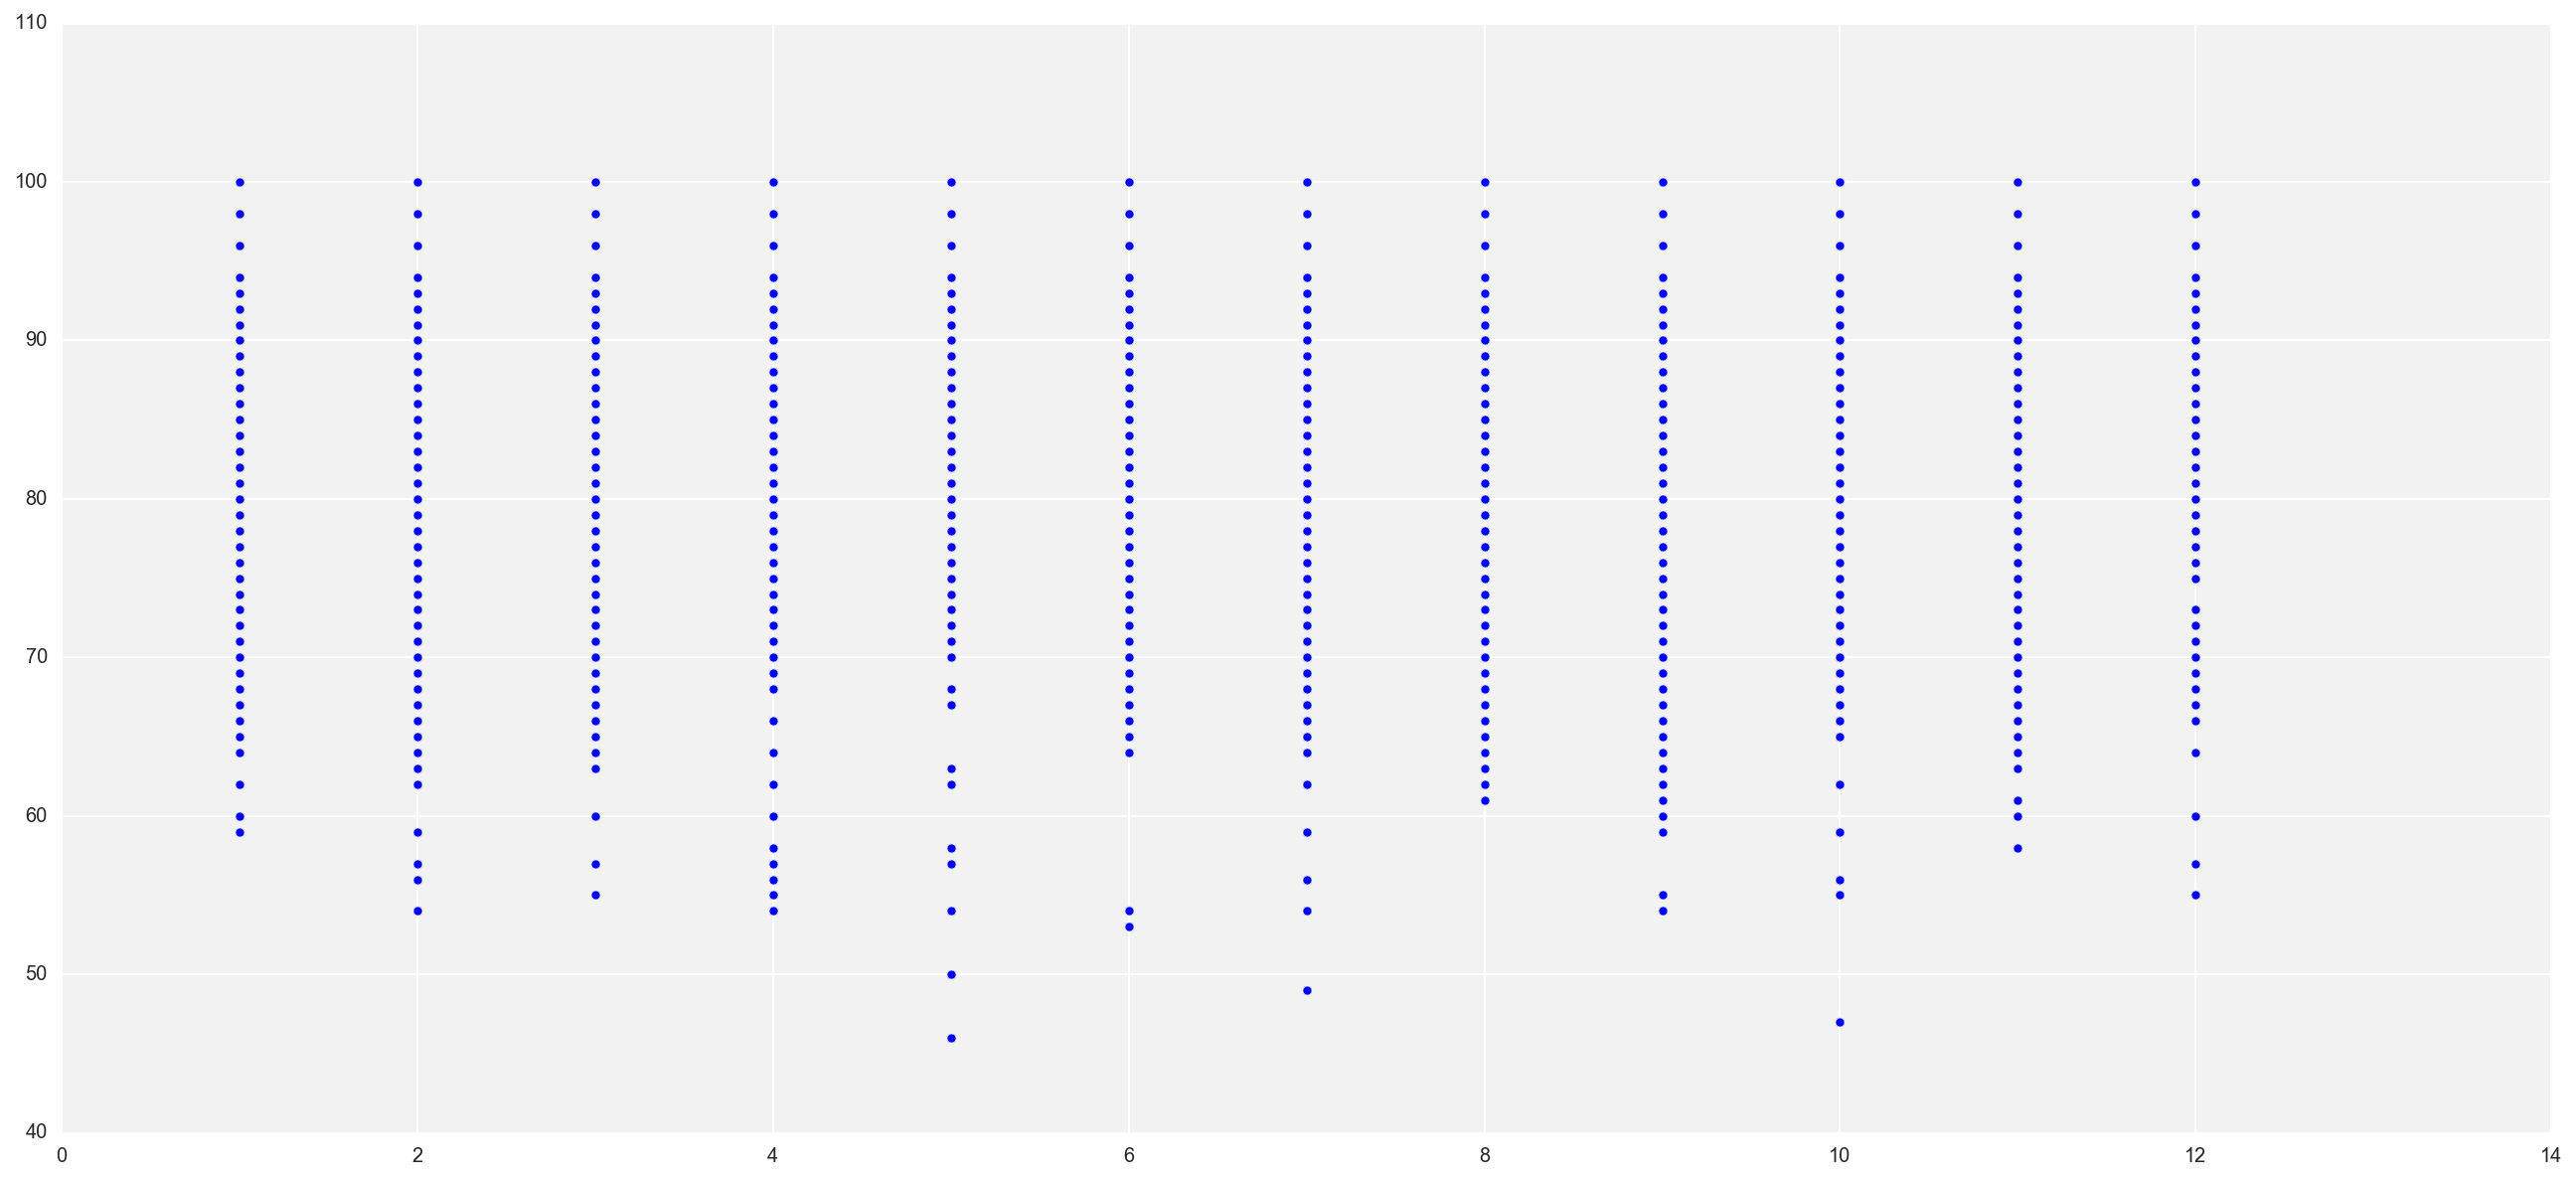

In [49]:
#I guess this is slightly informative
plt.figure(figsize=(20,10))
plt.scatter(interesting_vars['month'], interesting_vars['score'])
plt.show()

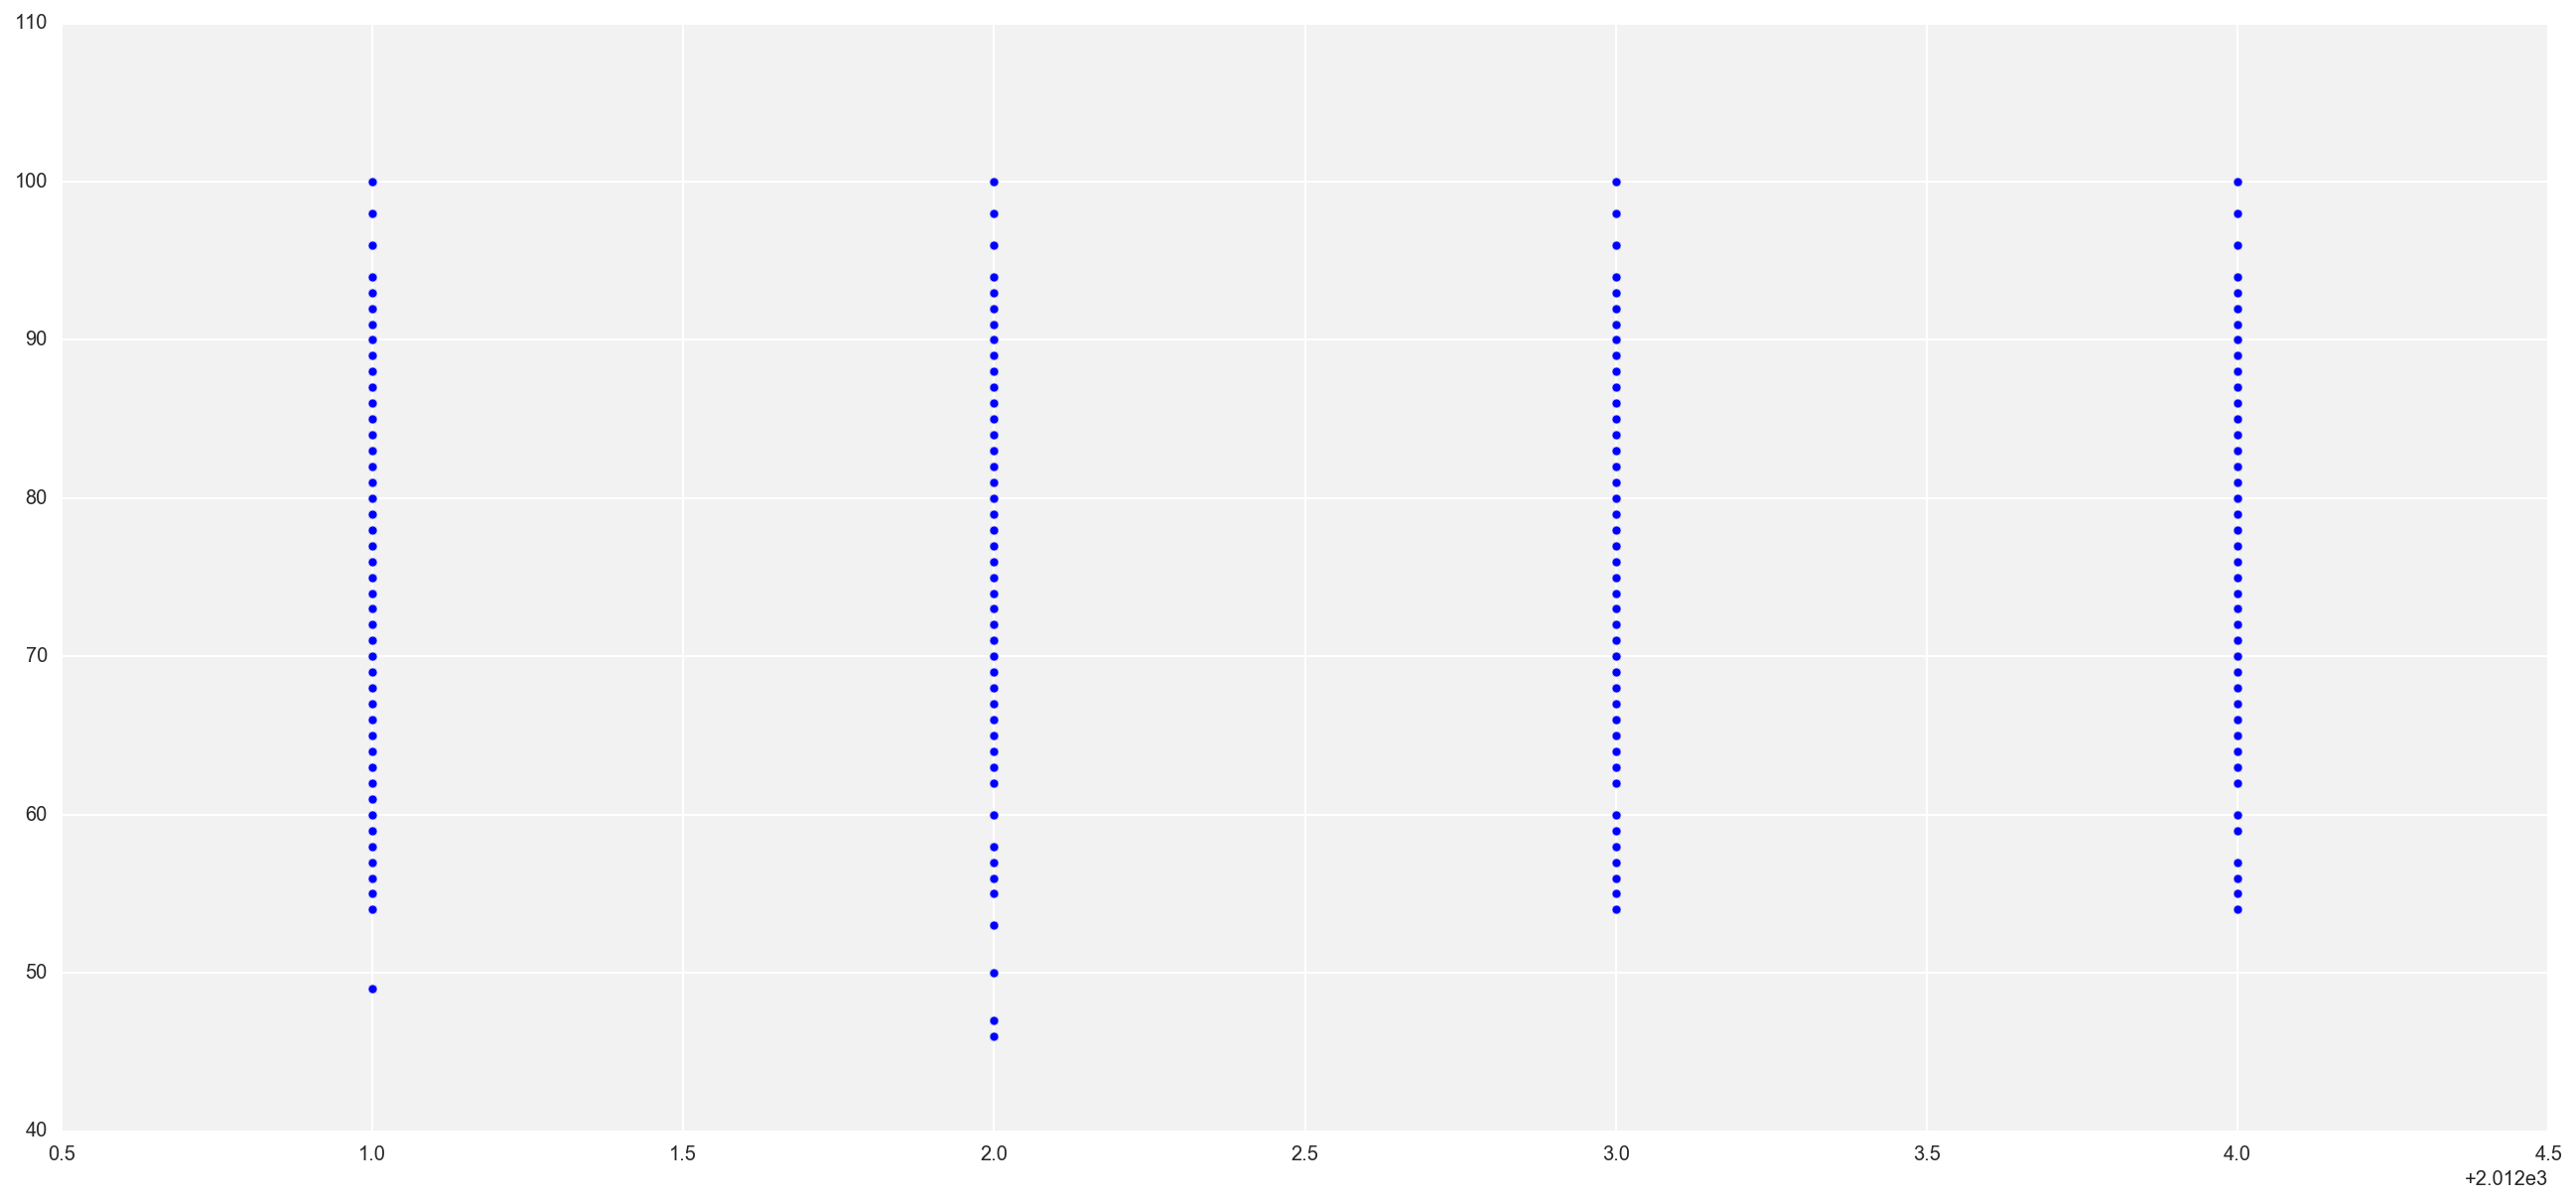

In [50]:
plt.figure(figsize=(20,10))
plt.scatter(interesting_vars['year'], interesting_vars['score'])
plt.show()

My plotting could be better... I'd like to do a lot more of it but again time management... because I want to get to linear regression!

In [51]:
# violations_parsed.columns[0:20]

# wanted_columns = list([c for c in violations_parsed.columns[0:20] if c in interesting_vars.columns])+list(violations_parsed.columns[20:])

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 2. Construct and evaluate a linear regression model on the data

---

1. State the variables that are predictors in your linear regression and the target variable.
- Investigate and remove any outliers or other problems in your data. _This is a subjective process._
- Construct a linear regression model.
- Evaluate the model. How does the $R^2$ of the overall model compare to cross-validated $R^2$. What do the differences in $R^2$ mean?
  - Use test / train split
  - Use K-Folds
  - Compare and explain your results with both
- Visualize the evaluation metrics of your analysis in clear charts.
- Summarize your results in the context of your hypothesis. Frame this as if you are presenting to non-technical readers.


In [52]:
interesting_vars.columns

Index([u'score', u'date', u'month', u'year', u'violation_count',
       u'days_since_first_violation', u'neighborhood', u'population',
       u'business_count'],
      dtype='object')

In [53]:
#specifying target and predictor variables - let patsy convert to binary
formula = 'score ~ C(month) + C(year) + C(violation_count) + days_since_first_violation +\
C(neighborhood) + population + business_count -1'

In [54]:
#using patsy to create design matrices - matrix of values of explanatory variables
y, X = patsy.dmatrices(formula, data=interesting_vars, return_type='dataframe')

In [55]:
y = np.ravel(y)

In [56]:
y.shape

(32455,)

In [57]:
X.shape

(32455, 68)

In [58]:
#I haven't removed any outliers but I am standardizing/normalizing before linear regression...
#although my understanding is that this is only necessary when doing regularization so that beta values 
#are on the same scale to determine which to penalize based on their size

scaler = StandardScaler()
Xn = scaler.fit_transform(X)

In [59]:
#just wondering what kind of object this yields
Xn

array([[ 3.65174579, -0.30943392, -0.33067369, ..., -1.04798707,
        -0.46877625, -0.17001815],
       [ 3.65174579, -0.30943392, -0.33067369, ..., -1.04798707,
        -0.46877625, -0.17001815],
       [ 3.65174579, -0.30943392, -0.33067369, ..., -1.04798707,
        -0.46877625, -0.17001815],
       ..., 
       [-0.27384162, -0.30943392, -0.33067369, ...,  2.03235141,
        -0.58570228, -1.03522203],
       [-0.27384162, -0.30943392, -0.33067369, ...,  2.03235141,
        -0.58570228, -1.03522203],
       [-0.27384162, -0.30943392, -0.33067369, ...,  2.03235141,
        -0.58570228, -1.03522203]])

In [60]:
#creating a test/train sets to properly evaluate my resulting R^2 scores

X_train, X_test, y_train, y_test =  train_test_split(Xn, y, test_size=0.3)

print y_train.shape, X_train.shape
print y_test.shape, X_test.shape

(22718,) (22718, 68)
(9737,) (9737, 68)


In [61]:
#linear regression on test/train
lr = LinearRegression()

#fit model on training
model = lr.fit(X_train, y_train)

#predict using test
test_train_predictions = model.predict(X_test)

#score using test
test_train_score = model.score(X_test, y_test)

print 'Test/Train R^2:', test_train_score


Test/Train R^2: 0.119031568419


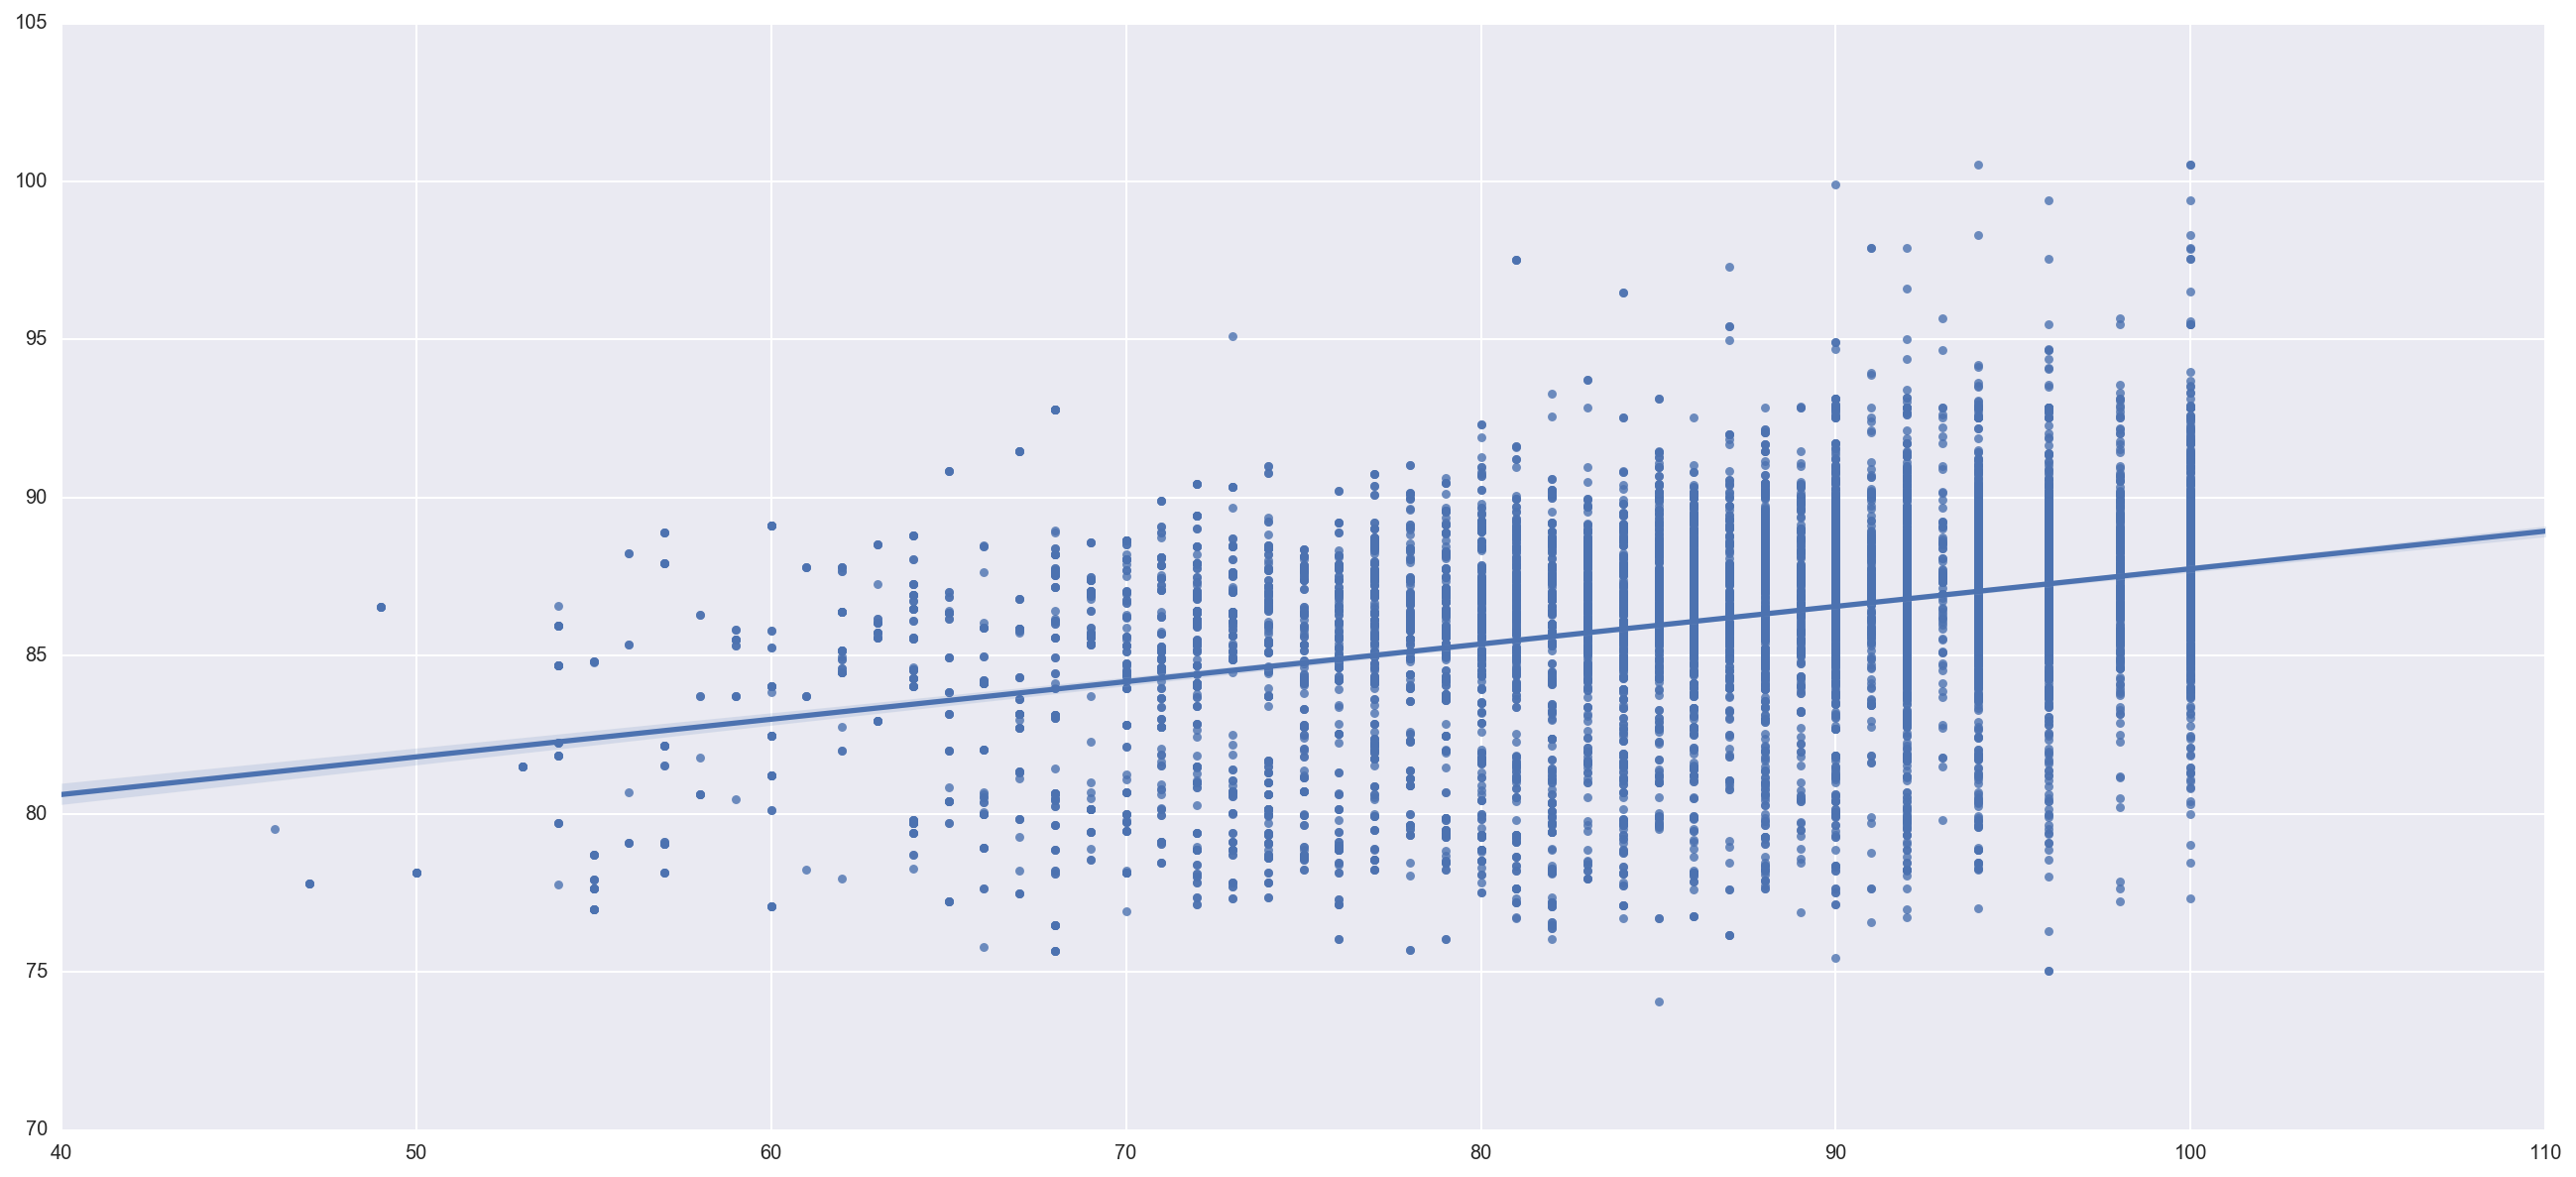

In [62]:
#plot
sns.set(rc={"figure.figsize": (20, 10)})
sns.regplot(x = y_test, y = test_train_predictions)
plt.show()

In [63]:
y_test.shape

(9737,)

In [64]:
#????
test_train_predictions.shape

(9737,)

In [65]:
#linear regression with 10 fold cross-validation on test/train

cv_scores = cross_val_score(lr, X_test, y_test, cv=10)

print 'CV R^2s:', cv_scores
print 'Mean CV R^2:', np.mean(cv_scores)

#make cross-validated predictions
cv_predictions = cross_val_predict(lr, X_test, y_test, cv=10)


CV R^2s: [ 0.11080355  0.12321694  0.12951788  0.08853721  0.09386418  0.099679
  0.14118484  0.11490609  0.12952837  0.1004531 ]
Mean CV R^2: 0.11316911418


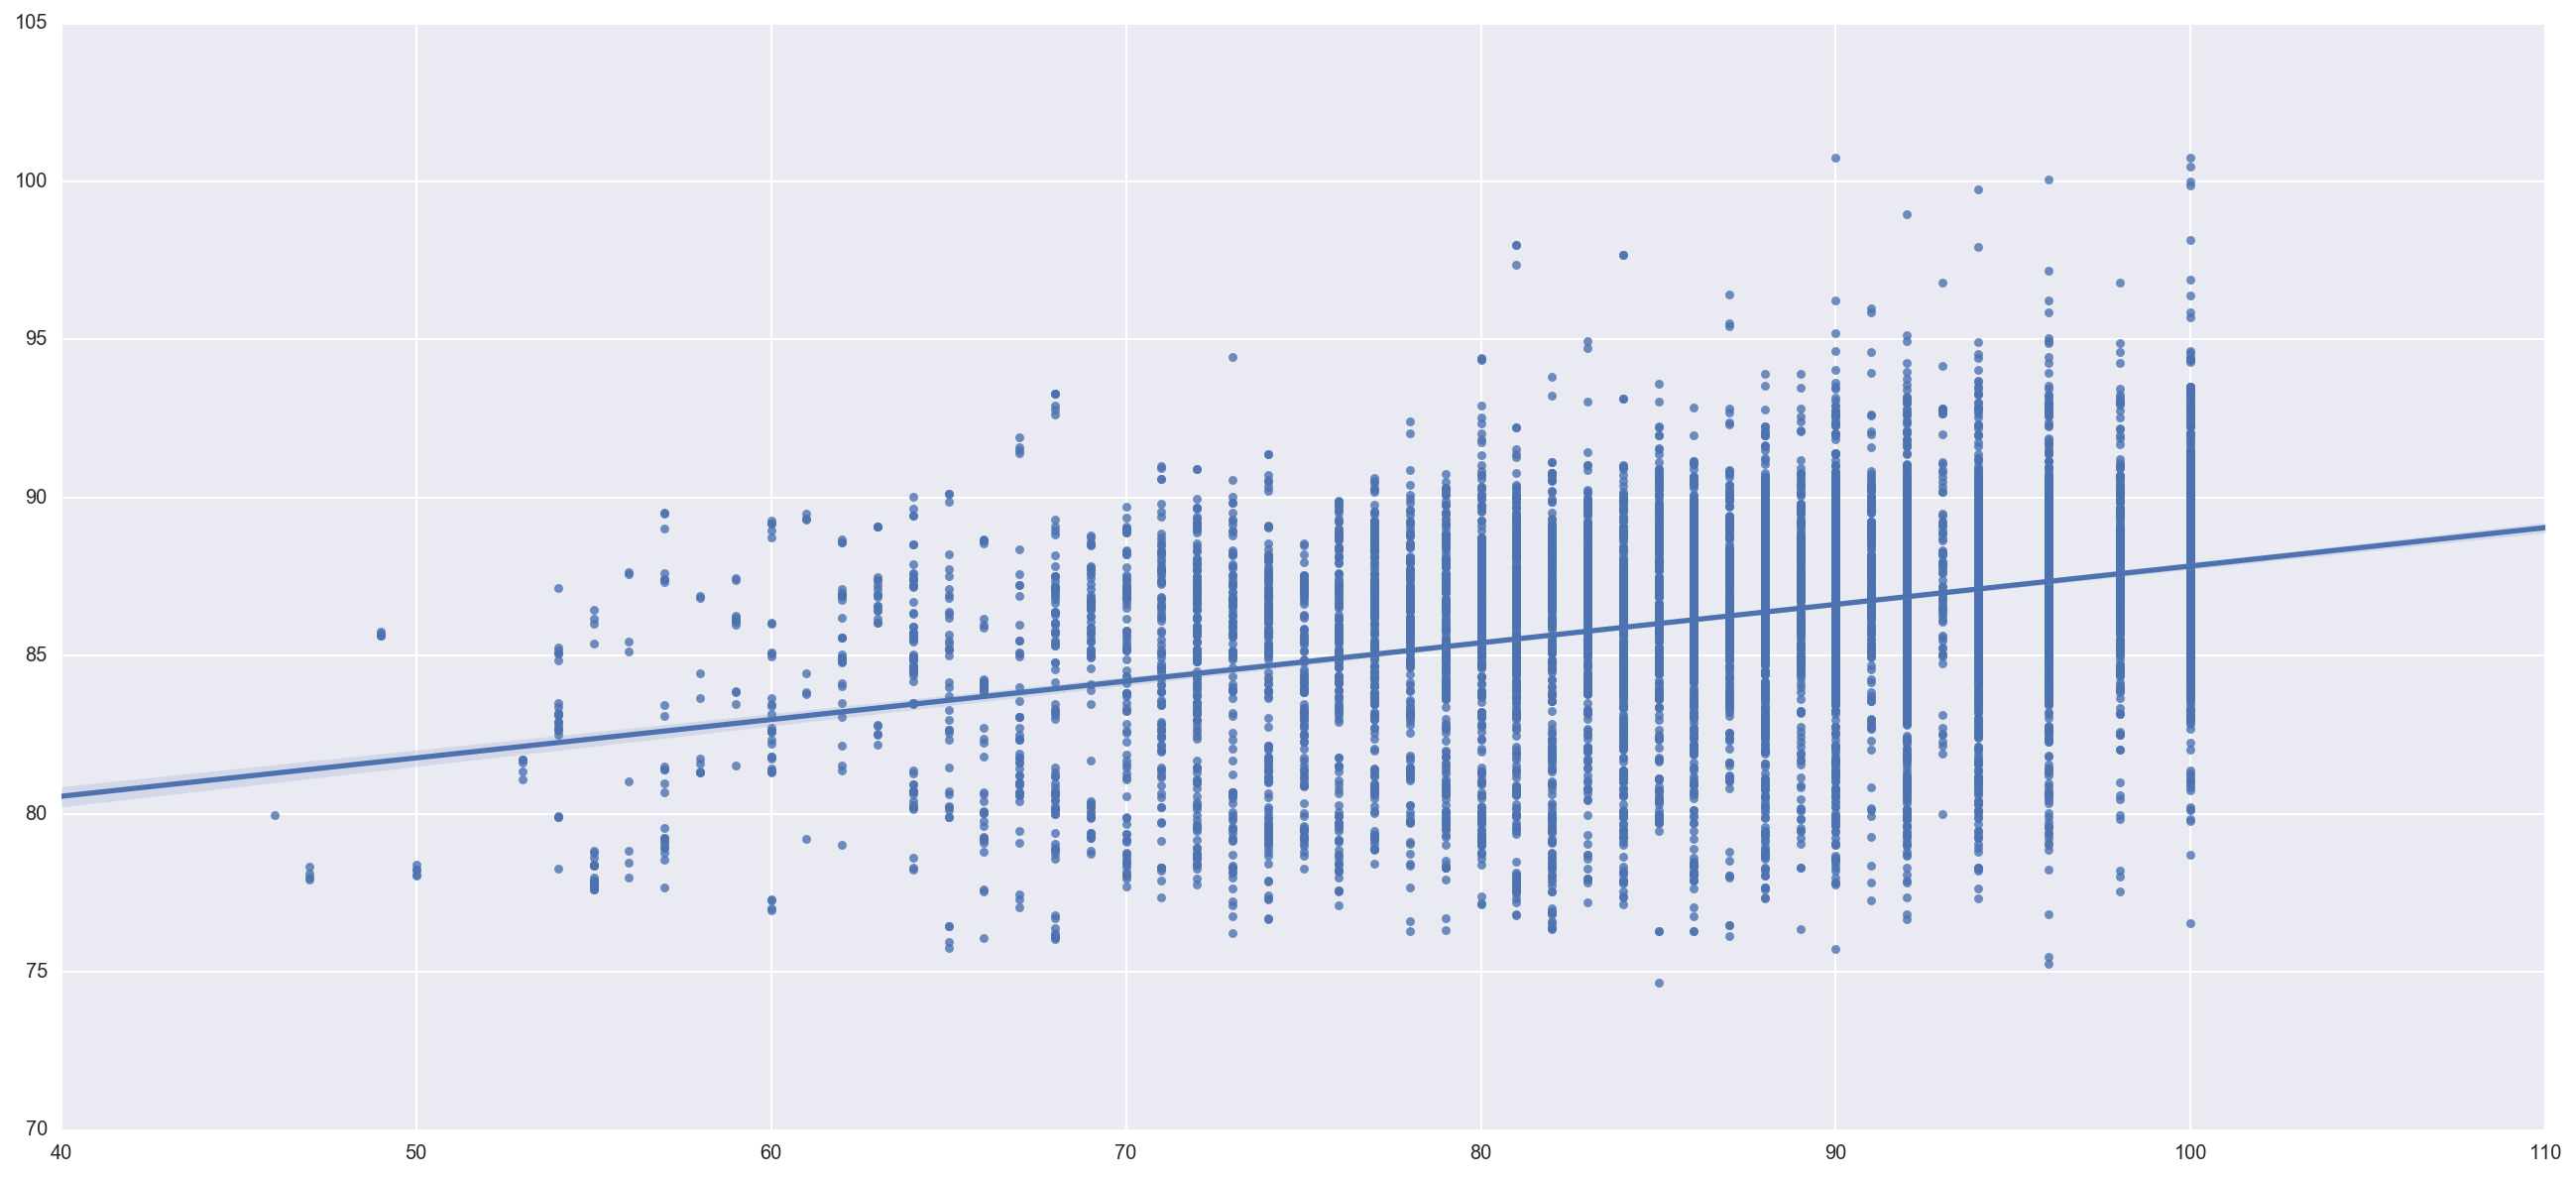

In [67]:
#plot
sns.set(rc={"figure.figsize": (20, 10)})
sns.regplot(x = y_test, y = cv_predictions)
plt.show()

### Results summary:

The variables I selected as my predictor variables for predicting score have very little predictive power but are slightly better than using just the baseline model (mean score) to predict score (the way I understand it is the baseline model has a R^2 of zero? or does it not make sense to think of it that way?).

As far as the pure test/train split Linear Regression vs the cross-validated Linear Regression I was expected the R^2 results from cross-validation to be worse than they were. The ended up being nearly the same as from test/train split. Perhaps something was wrong in my setup, but I'd expect cross-validated R^2s to be worse since the model is being exposed to an "unseen" version of each data point whereas my test/train split to only 30% "unseen".

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 2.2 Explain $R^2$ vs. mean squared error (MSE)

---

1. If you have negative $R^2$ values in cross-validation, what does this mean? 
2. Why can $R^2$ only be negative when the model is tested on new data?

If you have negative R^2 resulting from cross-validation it means your model doesn't make much sense given the data points. Another way to think about it is your model performs worse than the baseline model - just using the target variable's mean as a predictor.

R^2 can only be negative when the model is tested on new data because when Linear Regression fits on any dataset it always acts to minimize the sum of squares loss function which will never been worse than the baseline model (zero). However it can be negative on new data because it no longer fits the new data's distribution and now the sum of squares loss function increases resulting in a negative value. However, R^2 can never be greater than 1 because 1 means the regression line fits the data perfectly and sadly you can never be better than perfect. Essentially, Linear Regression tends to overfit and so you need to test on new data to get a more accurate sense of the model's predictive power.



<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 3. Combine multiple sources of data and evaluate a model with regularized regression

---

**I recommend having many predictors to see benefits from regularization methods, but it's up to you.**

1. Use _NEW_ sources of data for this section. It should not be related to your analysis/hypothesis from section 1.
- Like in part 1, you should state a hypothesis and perform data cleaning and EDA _only_ on the relevant portions of your data. Don't waste time!
- Construct and evaluate different models with cross-validated $R^2$. Compare LinearRegression, Lasso, Ridge, and ElasticNet. Find the optimal hyperparameters (alpha, l1_ratio) using gridsearch.
- Report on which model is best, and why that might be the case (hint: does your data have multicollinearity? Irrelevant variables? Both?)
- Plot visuals that compare the performance of the four models.


I kinda went rogue here and kept going with my original dataset because I wanted to explore the 373 binary columns... also I ran low on time

In [68]:
# list(violoations_bin)

In [72]:
#doing this without patsy becauce just couldn't get it to work here for some reason
y = violations_parsed.score.values
X = violations_parsed[binary_cols]

In [75]:
print y.shape
print X.shape

(32455,)
(32455, 373)


In [76]:
#skipping standardization/normalization 
#doesn't make sense to me to do this on binary data... but I could be wrong

#test/train split
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3)

In [77]:
#Linear Regression
lr = LinearRegression()

lr_model = lr.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

In [78]:
#Cross-validation
lr_cv_score = cross_val_score(lr_model, X_test, y_test, cv=5)
print "LR CV scores:", lr_cv_score
print "Mean score:",np.mean(lr_cv_score)

#I'm actually not sure what this does/means exactly?
cv_r2 = metrics.r2_score(y_test, lr_predictions)
print "CV R^2:", cv_r2

LR CV scores: [ -3.32427674e-02  -2.97984537e+22  -7.94867986e+23  -1.67793111e+23
  -1.66009822e+22]
Mean score: -2.01812106535e+23
CV R^2: -1.74322664103e+20


In [79]:
#lasso & gridsearch

search_parameters = {
    'alpha': np.arange(0, 5, 1)
}

lasso = Lasso()

estimator = GridSearchCV(lasso, search_parameters, cv=5, verbose=True, n_jobs=4)
results = estimator.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/VanessaG/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:1531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/VanessaG/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:1531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/VanessaG/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/VanessaG/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:1531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/VanessaG/anaconda/l

In [80]:
print "Best Lasso Score:"
print results.best_score_
print "Best Lasso Params:"
print results.best_params_

Best Lasso Score:
-0.000198724976997
Best Lasso Params:
{'alpha': 1}


In [81]:
predictions = results.predict(X_test)

In [82]:
#I'm really not sure what to make of these numbers... maybe I did something wrong?
#but then again these are from all the binary columns
model = Lasso(alpha=1.0).fit(X,y)
lasso_coef = model.coef_
print lasso_coef

[ 0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0.  0.  0. -0. -0.  0.  0.  0. -0. -0.  0.  0.
  0.  0. -0. -0. -0. -0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0. -0.
 -0. -0. -0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0.  0. -0. -0.  0.  0.
  0.  0.  0.  0. -0.  0.  0. -0.  0.  0.  0.  0. -0. -0.  0.  0. -0. -0.
  0.  0.  0. -0. -0. -0.  0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0.
  0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.  0.
  0.  0. -0. -0.  0.  0. -0. -0.  0. -0. -0.  0. -0. -0. -0.  0.  0. -0.
 -0. -0.  0. -0. -0.  0. -0.  0. -0. -0. -0.  0.  0.  0.  0.  0. -0. -0.
  0.  0. -0.  0. -0. -0.  0.  0. -0. -0. -0. -0.  0.  0. -0. -0.  0.  0.
 -0. -0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0.
  0.  0. -0. -0. -0.  0.  0. -0.  0. -0.  0. -0. -0. -0. -0. -0. -0.  0.
  0. -0.  0. -0. -0. -0. -0. -0. -0. -0.  0.  0. -0. -0. -0. -0.  0.  0.
  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 4. Conduct another, different analysis and report on it

---

1. Combining multiple sources of data (csv files) is required.
- Perform EDA and cleaning on relevant data.
- Construct and compare different regression models with cross-validation.
- Plot descriptive visuals you think are useful for understanding the data.
- Report on your findings.

This section is just another analysis like the first sections, but is more open-ended in what models you decide to build and why. Don't feel obligated to try every out every regularized regression model (though it doesn't hurt). 


<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 4.2 Ploting GridSearch with Lasso, Ridge, or Elasticnet
---
1. Using the gridsearch results, plot your score in relation to your parameters.
1. Plot the effect on your coefficients given alpha.
1. Plot any other parameter change to visualize the impact of any other hyperparameter.

It's helpful to understand the impact of parameters used in Gridsearch, and that you are comfortable working with the data that is generated for reporting to explore the results visually.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. Bias-variance tradeoff

---

1. Select San Francisco data of your choice and construct a regularized regression model (this can be data from an earlier analysis if you like). Ideally the model should actually improve across regularization strengths...
- Gridsearch the regularization parameters to find the optimal.
- Plot the regularization parameter against the cross-validated $R^2$.
- Explain how regularization and regularization strength is related to the bias-variance tradeoff.


<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5.1 Calculate the approximated $\text{bias}^2$ and variance across regularization strengths.

---

You can obviously use my code from the bias-variance lab to do this. 

Plot the bias and variance change _with_ the cross-validated $R^2$. 

You'll need to scale these values somehow to put them on the same chart (I recommend (MinMaxScaler)[http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html] to put $\text{bias}^2$ and variance on the same scale as cross-validated $R^2$.

<img src="http://imgur.com/HNPKfE8.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 6. Custom regularized regression penalties

---

The $\lambda1$ and $\lambda2$ norm regularization penalties (Lasso and Ridge) are the most commonly used regularization penalties. They have a solid foundation in statistics and evidence of effectiveness. However, these are not the only possible penalties for regression – sometimes new, customized penalties give additional performance and predictive power to models depending on the context.

For example, when I worked in neuroscience [we created an effective penalized regression dubbed "GraphNet"](http://arxiv.org/abs/1110.4139) that combined the Lasso and Ridge penalties like in Elastic net with a third penalty that rewarded clustering of coefficients according to physical distance in FMRI brain activation data.

**Devise of and implement a penalized regression for San Francisco data.** What is your rationale – why would this be useful? How does it perform compared to the standard Ridge, Lasso, and Elastic Net penalties?